In [3]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(
    model = "gpt-4o", temperature = 0 
)

In [6]:
embeddings = OpenAIEmbeddings(
   model = "text-embedding-3-small"
)

In [7]:
pdf_path = "Stock_Market_Performance_2024.pdf"

In [8]:
# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF

In [10]:
# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise

PDF has been loaded and has 9 pages


In [11]:
pages

[Document(metadata={'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250411184712', 'source': 'Stock_Market_Performance_2024.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='Stock Market Performance in 2024\nU.S. Market Overview\nThe year 2024 was a remarkably strong one for equities, with the U.S. stock market extending the\nrobust gains seen in the prior year. The benchmark S&P 500 index delivered roughly a 25% total\nreturn for 2024 (around +23% in price terms)\n. This marked the second consecutive year of over 20% returns for the S&P 500 - a feat not\nobserved since the late 1990s\n. The tech-heavy Nasdaq Composite outpaced the broader market, jumping nearly 29% for the year\n. In contrast, smaller-cap stocks had more modest performance: the S&P 500 Equal-Weight index\nand the Russell 2000 (small-cap benchmark) each rose about 10-11% in 2024\n. The disparity underscored that 2024\'s rally was not evenly distribut

In [12]:
# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [13]:
pages_split = text_splitter.split_documents(pages) # We now apply this to our pages

In [14]:
persist_directory = r"C:\Users\HP\Desktop\Gen-AI\langgraph_project\research"
collection_name = "stock_market"

In [15]:
# If our collection does not exist in the directory, we create using the os command
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

In [16]:
try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise

Created ChromaDB vector store!


In [17]:
# Now we create our retriever 
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

In [18]:
retriever.invoke("what is the growth")

[Document(id='710e2676-033f-41d0-8a9e-372d8626eb40', metadata={'page': 7, 'page_label': '8', 'creationdate': 'D:20250411184712', 'creator': 'PyPDF', 'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'source': 'Stock_Market_Performance_2024.pdf', 'total_pages': 9}, page_content='rich multiples, pricing in a lot of optimism for future growth. The exuberance of 2024 did create a\n"frothy" sentiment environment, as analysts at Schwab noted\n, meaning investors had become very bullish and perhaps complacent. This backdrop raised some\nconcern that volatility could return if the anticipated growth failed to materialize or if macroeconomic\nfactors turned unfriendly. As 2025 began, market participants were balancing the excitement about\ntechnology-driven growth against the reality of elevated price levels. The strong 2024 stock\nperformance undoubtedly rewarded investors, but it also set a high bar for future earnings and'),
 Document(id='d83bfc02-d218-4dea-83b5-932c57693a13', metada

In [19]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [20]:
tools = [retriever_tool]

In [21]:
llm = llm.bind_tools(tools)

In [22]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [23]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [24]:
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [25]:
tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools

In [26]:
# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [27]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [28]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

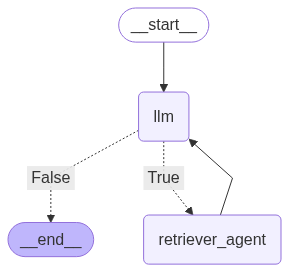

In [30]:
from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [31]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

In [32]:
running_agent()


=== RAG AGENT===
Calling Tool: retriever_tool with query: most performed stock in 2024
Result length: 4664
Tools Execution Complete. Back to the model!

=== ANSWER ===
The most performed stock in 2024 was Meta, which saw a 72% gain. This was part of a broader trend where online advertising and social media companies, especially those that significantly boosted their earnings and cash flow, returned to favor. Additionally, Tesla also had a strong performance with a 63% gain despite experiencing volatility throughout the year (Document 2). The "Magnificent 7" group of mega-cap technology stocks, including Apple, Microsoft, Alphabet, Amazon, Meta, Nvidia, and Tesla, collectively surged by roughly 64-67% on average, contributing significantly to the S&P 500's gains (Document 4).
Calling Tool: retriever_tool with query: most performed stocks in 2024
Result length: 4664
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: profit of Apple and Meta in 2024
Res